# Proton Spin Up

In [1]:
import ipywidgets as widgets
from ipywidgets import interact, IntSlider
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from scipy import optimize
from scipy.optimize import curve_fit
from matplotlib.ticker import MaxNLocator

## Polarization vs Time

<Axes: title={'center': 'Polarization Over Time'}, xlabel='Datetime', ylabel='Polarization'>

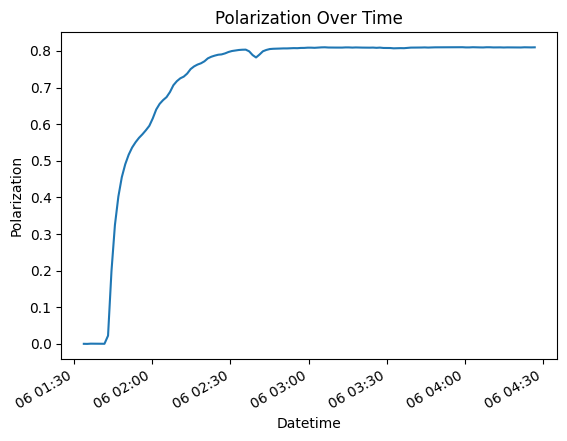

In [2]:

with open("2022-11-05_23-29-51__2022-11-06_11-20-39.txt","r") as eventfile:
    df = pd.read_json(eventfile, lines=True)
df['stop_time'] = pd.to_datetime(df['stop_time'])
df.set_index('stop_time', inplace=True)

df['pol'].plot(title='Polarization Over Time',
                      xlabel='Datetime',
                      ylabel='Polarization')


## Interactive Plot, Drag Slider to Select Result Curve

In [3]:
def plot_pol_array(index):
    plt.figure(figsize=(10, 6))
    signal_array = df.iloc[index]['rescurve']  # Get array from selected row
    plt.plot(signal_array, linewidth=2)
    plt.title(f"Result Signal {index} (Polarization: {df.iloc[index]['pol']:.2f})")
    plt.grid(True, alpha=0.3)
    plt.show()


# Create interactive widget
interact(plot_pol_array,
         index=IntSlider(min=0, max=len(df)-1, step=1, value=9,
                         description='Row Index:'))


interactive(children=(IntSlider(value=9, description='Row Index:', max=131), Output()), _dom_classes=('widget-…

<function __main__.plot_pol_array(index)>

In [4]:
# Define Gaussian(s)
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x - cen)**2 / (2 * wid**2))

def three_gaussians(x, *params):
    return sum(gaussian(x, *params[i:i+3]) for i in range(0, 9, 3))

# Store fit results
fit_results = []

# Fit and plot individual curve
def plot_pol_array_with_fit(index):
    plt.figure(figsize=(10, 6))
    signal_array = df.iloc[index]['rescurve']
    x_data = np.arange(len(signal_array))

    mean_val = np.mean(signal_array)
    initial_guess = [
        mean_val / 3, len(signal_array) / 4, 100,
        mean_val / 3, len(signal_array) / 2, 100,
        mean_val / 3, 3 * len(signal_array) / 4, 100
    ]

    popt, _ = curve_fit(three_gaussians, x_data, signal_array, p0=initial_guess)

    # Append results
    fit_results.append({
        'index': index,
        'time': df.index[index],
        'pol': df.iloc[index]['pol'],
        'params': popt
    })

    # Plot original and fit
    plt.plot(x_data, signal_array, label='Original Signal', linewidth=2)
    plt.plot(x_data, three_gaussians(x_data, *popt), '--', color='red', label='Total Fit')

    # Plot Gaussians
    colors = ['blue', 'green', 'purple']
    for i in range(3):
        amp, cen, wid = popt[i*3:i*3+3]
        label = f'Gaussian{i+1}: Amplitude={amp:.4f}, Center={cen:.1f}, Width={np.abs(wid):.1f}'
        g = gaussian(x_data, amp, cen, wid)
        plt.plot(x_data, g, linestyle=':', color=colors[i], label=label)

    plt.title(f"Signal {index} | Polarization: {df.iloc[index]['pol']:.2f}")
    plt.xlabel("Index")
    plt.ylabel("Signal")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# Create slider
interact(plot_pol_array_with_fit,
         index=IntSlider(min=0, max=len(df)-1, step=1, value=9, description='Row Index:'))






interactive(children=(IntSlider(value=9, description='Row Index:', max=131), Output()), _dom_classes=('widget-…

<function __main__.plot_pol_array_with_fit(index)>

C:\Users\Direc\AppData\Local\Temp\ipykernel_7744\2459469044.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(three_gaussians, x_data, signal_array, p0=initial_guess)


ValueError: s must be a scalar, or float array-like with the same size as x and y

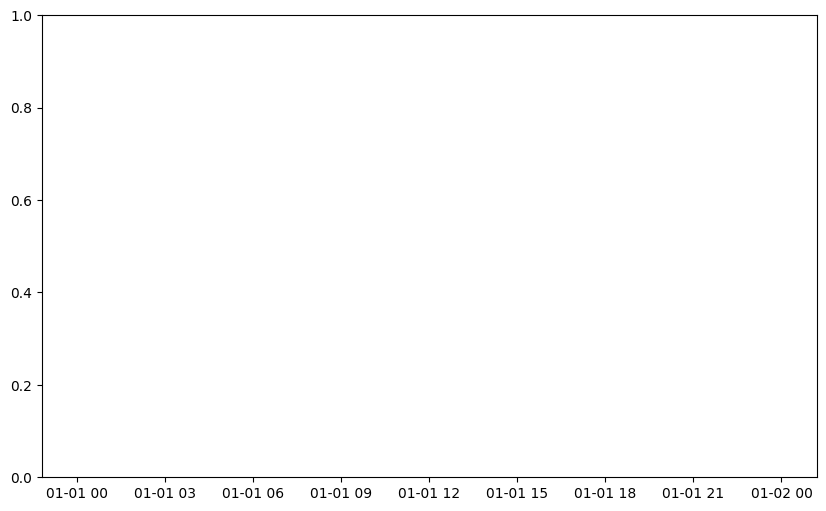

In [5]:
# Re-initialize fit_results
fit_results = []

# Loop over all indexes in df and fit the signal without plotting
for index in range(len(df)):
    signal_array = df.iloc[index]['rescurve']
    x_data = np.arange(len(signal_array))

    mean_val = np.mean(signal_array)
    initial_guess = [
        mean_val / 3, len(signal_array) / 4, 100,
        mean_val / 3, len(signal_array) / 2, 100,
        mean_val / 3, 3 * len(signal_array) / 4, 100
    ]

    try:
        popt, _ = curve_fit(three_gaussians, x_data, signal_array, p0=initial_guess)
        fit_results.append({
            'index': index,
            'time': df.index[index],
            'pol': df.iloc[index]['pol'],
            'params': popt
        })

    except RuntimeError:
        # If fit fails, append NaNs to keep indexing consistent
        fit_results.append({
            'index': index,
            'time': df.index[index],
            'pol': df.iloc[index]['pol'],
            'params': [np.nan]*9
        })

# Convert fit results to DataFrame
fit_df = pd.DataFrame(fit_results)

# Plot the amplitude values of each Gaussian over time
plt.figure(figsize=(10, 6))
for i in range(3):
    amps = fit_df['params'].apply(lambda p: p[i*3] if isinstance(p, (list, np.ndarray)) else np.nan)
    
    # Filter out outliers
    filtered_amps = amps.where(amps > -0.02)
    
    plt.scatter(fit_df['time'], filtered_amps, 'o-', label=f'Gaussian {i+1} amplitude')
    

plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Gaussian Amplitudes vs Time')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

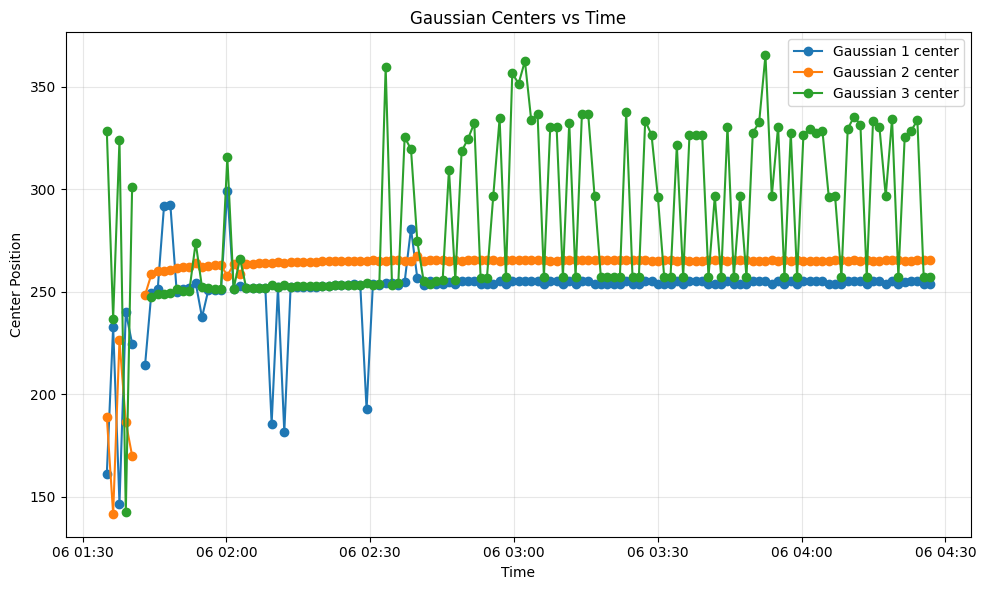

In [ ]:
# Plot the center positions of each Gaussian over pulse index
plt.figure(figsize=(10, 6))
for i in range(3):
    centers = fit_df['params'].apply(lambda p: p[i*3+1] if isinstance(p, (list, np.ndarray)) else np.nan)
    filtered_centers = centers.where((centers < 1200), np.nan)
    plt.plot(fit_df['time'], filtered_centers, 'o-', label=f'Gaussian {i+1} center')

plt.xlabel('Time')
plt.ylabel('Center Position')
plt.title('Gaussian Centers vs Time')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

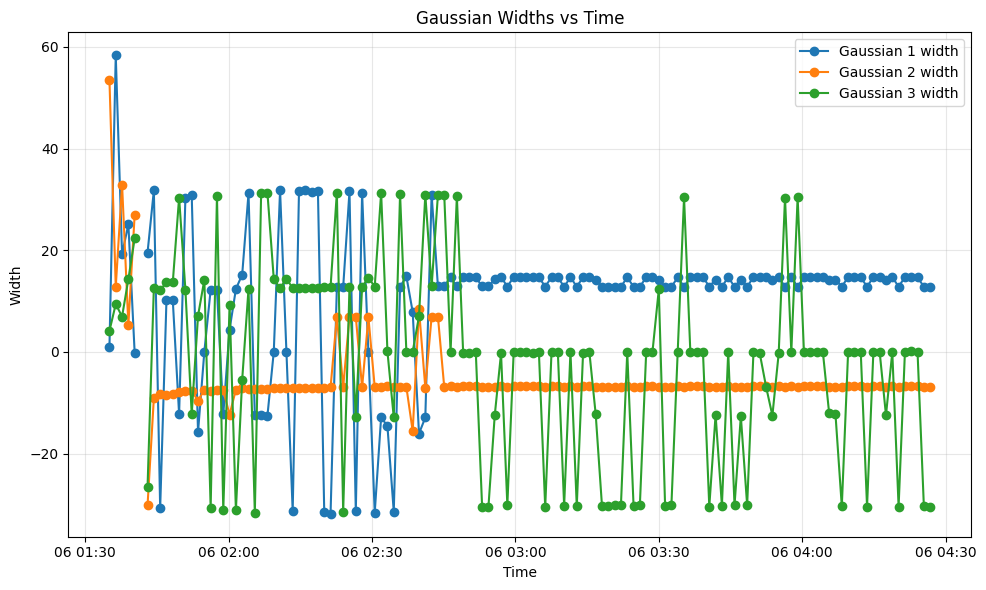

In [ ]:
# Plot the width values of each Gaussian over pulse index
plt.figure(figsize=(10, 6))
for i in range(3):
    widths = fit_df['params'].apply(lambda p: p[i*3+2] if isinstance(p, (list, np.ndarray)) else np.nan)
    
    plt.plot(fit_df['time'], widths, 'o-', label=f'Gaussian {i+1} width')

plt.xlabel('Time')
plt.ylabel('Width')
plt.title('Gaussian Widths vs Time')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Make Time_steps list
time = df['pol'].index

# Create lists for Gaussian Variables
amp1_list = []
cen1_list = []
wid1_list = []
amp2_list = []
cen2_list = []
wid2_list = []
amp3_list = []
cen3_list = []
wid3_list = []
amp1_error = []
cen1_error = []
wid1_error = []
amp2_error = []
cen2_error = []
wid2_error = []
amp3_error = []
cen3_error = []
wid3_error = []

def plot_pol_array_with_fit(index):
    signal_array = df.iloc[index]['rescurve'] # Get array from selected row
    x_data = np.arange(len(signal_array))


    # Initial guess fir the parameters
    mean_val = np.mean(signal_array)
    initial_guess = [
        mean_val / 3, len(signal_array) / 4, 100,
        mean_val / 3, len(signal_array) / 2, 100,
        mean_val / 3, 3 * len(signal_array) / 4, 100
    ]

    try:
        # Perform curve fitting
        popt, pcov = curve_fit(three_gaussians, x_data, signal_array, p0=initial_guess)
        perr = np.sqrt(np.diag(pcov))
        # Plot fitted Gaussian curves
        fitted_curve = three_gaussians(x_data, *popt)

        amp1_list.append(popt[0])
        cen1_list.append(popt[1])
        wid1_list.append(popt[2])
        amp2_list.append(popt[3])
        cen2_list.append(popt[4])
        wid2_list.append(popt[5])
        amp3_list.append(popt[6])
        cen3_list.append(popt[7])
        wid3_list.append(popt[8])
        amp1_error.append(perr[0])
        cen1_error.append(perr[1])
        wid1_error.append(perr[2])
        amp2_error.append(perr[3])
        cen2_error.append(perr[4])
        wid2_error.append(perr[5])
        amp3_error.append(perr[6])
        cen3_error.append(perr[7])
        wid3_error.append(perr[8])

        return amp1_list, cen1_list, wid1_list, amp2_list, cen2_list, wid2_list, amp3_list, cen3_list, wid3_list, amp1_error, cen1_error, wid1_error, amp2_error, cen2_error, wid2_error, amp3_error, cen3_error, wid3_error
    
    except RuntimeError:
        amp1_list.append(np.nan)
        cen1_list.append(np.nan)
        wid1_list.append(np.nan)
        amp2_list.append(np.nan)
        cen2_list.append(np.nan)
        wid2_list.append(np.nan)
        amp3_list.append(np.nan)
        cen3_list.append(np.nan)
        wid3_list.append(np.nan)
        amp1_error.append(np.nan)
        cen1_error.append(np.nan)
        wid1_error.append(np.nan)
        amp2_error.append(np.nan)
        cen2_error.append(np.nan)
        wid2_error.append(np.nan)
        amp3_error.append(np.nan)
        cen3_error.append(np.nan)
        wid3_error.append(np.nan)
        print(f"Fit failed for row {index}")

In [ ]:
for i in range(len(df)):
    plot_pol_array_with_fit(i)

Fit failed for row 0
Fit failed for row 6


C:\Users\Direc\AppData\Local\Temp\ipykernel_2756\3521844125.py:39: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(three_gaussians, x_data, signal_array, p0=initial_guess)


In [ ]:
cen1 = np.mean(cen1_list[21:])
wid1 = np.mean(wid1_list[21:])
cen2 = np.mean(cen2_list[21:])
wid2 = np.mean(wid2_list[21:])
cen3 = np.mean(cen3_list[21:])
wid3 = np.mean(wid3_list[21:])
print(np.mean(cen3_list[21:]))

289.448228668395


In [ ]:
# Convert timestamp column to datetime
time_h['stop_time'] = pd.to_datetime(time_h['stop_time'])

# Extract time portion (hh:mm:ss) as string 
time_held = time_h['stop_time'].dt.time.astype(str).tolist()

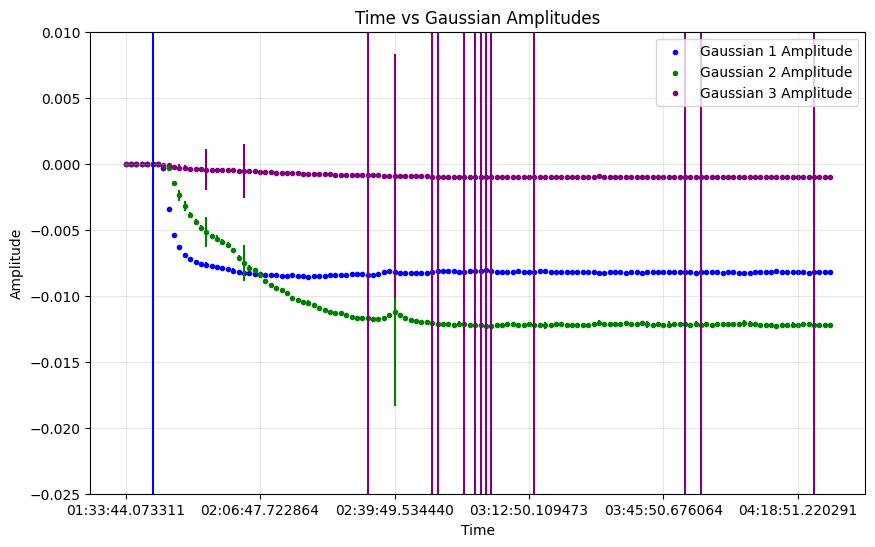

In [ ]:
plt.figure(figsize=(10, 6))

plt.scatter(time_held, amp1_held, label='Gaussian 1 Amplitude', color='blue', marker='.')
plt.errorbar(time_held, amp1_held, yerr=amp1_error, color='blue', ls=f' ')
plt.errorbar(time_held, amp2_held, yerr=amp2_error, color='green', ls=f' ')
plt.errorbar(time_held, amp3_held, yerr=amp3_error, color='purple', ls=f' ')
plt.scatter(time_held, amp2_held, label='Gaussian 2 Amplitude', color='green', marker='.')
plt.scatter(time_held, amp3_held, label='Gaussian 3 Amplitude', color='purple', marker='.')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title("Time vs Gaussian Amplitudes")
plt.grid(True, alpha=0.3)
ax = plt.gca() # Get current axes
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax.set_ylim(-0.025, 0.01)
plt.legend()

In [6]:

def held_gaussians(x, amp1, amp2, amp3):
    return (gaussian(x, amp1, cen1, wid1) + gaussian(x, amp2, cen2, wid2) + gaussian(x, amp3, cen3, wid3))

def plot_pol_array_with_fit(index):
    plt.figure(figsize=(10,6))
    signal_array = df.iloc[index]['rescurve']
    x_data = np.arange(len(signal_array))


    mean_val = np.mean(signal_array)

    initial_guess = [3*mean_val / 6,
                     2*mean_val / 6,
                     mean_val / 6]

    try:
        popt, _ = curve_fit(held_gaussians, x_data, signal_array, p0=initial_guess)
        print(popt)

        plt.plot(signal_array, linewidth=2, label='Original Signal')

        fitted_curve = held_gaussians(x_data, *popt)
        plt.plot(fitted_curve, linestyle='--', color='red', label='Fitted Curve')

        gauss1 = gaussian(x_data, popt[0], cen1, wid1)
        gauss2 = gaussian(x_data, popt[1], cen2, wid2)
        gauss3 = gaussian(x_data, popt[2], cen3, wid3)

        plt.plot(gauss1, linestyle=':', color='blue', label='Gaussian 1')
        plt.plot(gauss2, linestyle=':', color='green', label='Gaussian 2')
        plt.plot(gauss3, linestyle=':', color='purple', label='Gaussian 3')

        plt.title(f'Result Signal {index} (Polarization: {df.iloc[index]["pol"]:.2f})')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

    except RuntimeError:
        print(f'Fit failed for row {index}')


interact(plot_pol_array_with_fit, index=IntSlider(min=0, max=len(df) - 1, step=1, value=9, description='Row Index:'))


<Figure size 1000x600 with 0 Axes>

interactive(children=(IntSlider(value=9, description='Row Index:', max=131), Output()), _dom_classes=('widget-…

<function __main__.plot_pol_array_with_fit(index)>

In [ ]:
# Make time steps list
time_h = pd.DataFrame(df['pol'].index)

# Make empty list for Gaussian variables
amp1_held = []
amp2_held = []
amp3_held = []
amp1_error = []
amp2_error = []
amp3_error = []

def plot_pol_array_with_fit(index):
    plt.figure(figsize=(10,6))
    signal_array = df.iloc[index]['rescurve']
    x_data = np.arange(len(signal_array))

    # Initial guess for parameters of each gaussian
    mean_val = np.mean(signal_array)

    initial_guess = [3*mean_val / 6,
                     2*mean_val / 6,
                     mean_val / 6]

    try:
        # Perform curve fitting
        popt, pcov = curve_fit(held_gaussians, x_data, signal_array, p0=initial_guess)
        perr = np.sqrt(np.diag(pcov))

        amp1_held.append(popt[0])
        amp2_held.append(popt[1])
        amp3_held.append(popt[2])
        amp1_error.append(perr[0])
        amp2_error.append(perr[1])
        amp3_error.append(perr[2])  
              

        return amp1_held, amp2_held, amp3_held, amp1_error, amp2_error, amp3_error
    
    except RuntimeError:
        amp1_held.append(np.nan)
        amp2_held.append(np.nan)
        amp3_held.append(np.nan)
        amp1_error.append(np.nan)
        amp2_error.append(np.nan)
        amp3_error.append(np.nan)
        print(f"Fit failed for row {index}")

In [ ]:
for i in range(len(time_h)):
    plot_pol_array_with_fit(i)

C:\Users\Direc\AppData\Local\Temp\ipykernel_2756\3661981048.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,6))


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [ ]:
for i in range(len(time_h)):
    if amp1_list[i] == np.nan:
        amp1_list[i].pop()
        amp2_list[i].pop()
        amp3_list[i].pop()
        time[i].pop()


In [ ]:
# Convert timestamp column to datetime
time_h['stop_time'] = pd.to_datetime(time_h['stop_time'])

# Extract time portion (hh:mm:ss) as string 
time_held = time_h['stop_time'].dt.time.astype(str).tolist()


<function matplotlib.pyplot.show(close=None, block=None)>

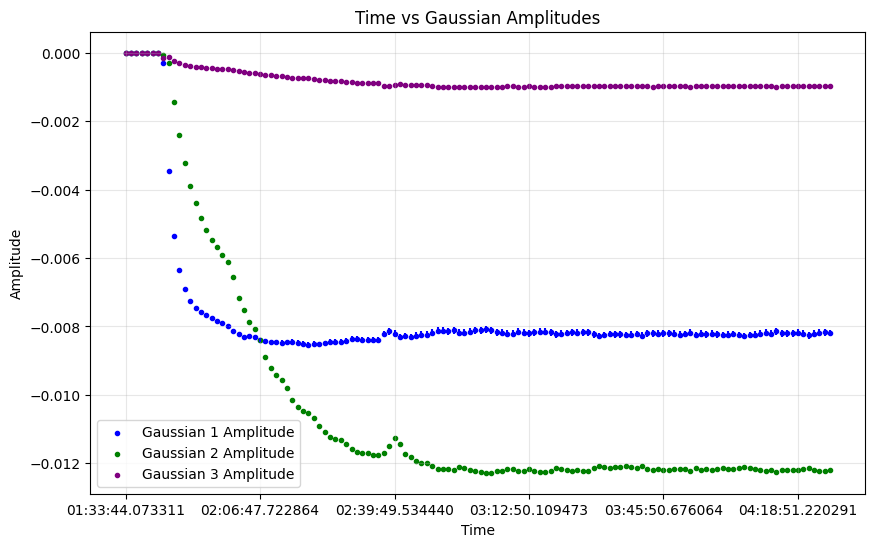

In [ ]:
plt.figure(figsize=(10, 6))

plt.scatter(time_held, amp1_held, label='Gaussian 1 Amplitude', color='blue', marker='.')
plt.errorbar(time_held, amp1_held, yerr=amp1_error, color='blue', ls=f' ')

plt.scatter(time_held, amp2_held, label='Gaussian 2 Amplitude', color='green', marker='.')
plt.scatter(time_held, amp3_held, label='Gaussian 3 Amplitude', color='purple', marker='.')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title("Time vs Gaussian Amplitudes")
plt.grid(True, alpha=0.3)
ax = plt.gca() # Get current axes
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
plt.legend()
plt.show

In [ ]:
# Updated plot and fit function
def plot_pol_array_with_fit(index):
    plt.figure(figsize=(10,6))
    signal_array = df.iloc[index]['rescurve']
    x_data = np.arange(len(signal_array))

    mean_val = np.mean(signal_array)
    initial_guess = [3*mean_val / 6, 2*mean_val / 6, mean_val / 6]

    try:
        # Perform the fit and extract covariance matrix
        popt, pcov = curve_fit(held_gaussians, x_data, signal_array, p0=initial_guess)

        # Extract standard deviations (sqrt of diagonal of covariance matrix)
        perr = np.sqrt(np.diag(pcov))

        # Print parameters and uncertainties
        for i, (amp, err) in enumerate(zip(popt, perr), start=1):
            print(f"Amplitude {i}: {amp:.6f} ± {err:.6f}")

        # Plot original and fitted curves
        plt.plot(signal_array, linewidth=2, label='Original Signal')
        fitted_curve = held_gaussians(x_data, *popt)
        plt.plot(fitted_curve, linestyle='--', color='red', label='Fitted Curve')

        # Plot individual Gaussians
        gauss1 = gaussian(x_data, popt[0], cen1, wid1)
        gauss2 = gaussian(x_data, popt[1], cen2, wid2)
        gauss3 = gaussian(x_data, popt[2], cen3, wid3)

        plt.plot(gauss1, linestyle=':', color='blue', label='Gaussian 1')
        plt.plot(gauss2, linestyle=':', color='green', label='Gaussian 2')
        plt.plot(gauss3, linestyle=':', color='purple', label='Gaussian 3')

        plt.title(f'Result Signal {index} (Polarization: {df.iloc[index]["pol"]:.2f})')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

    except RuntimeError:
        print(f'Fit failed for row {index}')
    except Exception as e:
        print(f"Unexpected error: {e}")

# Run interact
interact(plot_pol_array_with_fit, index=IntSlider(min=0, max=len(df) - 1, step=1, value=9, description='Row Index:'))

interactive(children=(IntSlider(value=9, description='Row Index:', max=131), Output()), _dom_classes=('widget-…

<function __main__.plot_pol_array_with_fit(index)>

In [ ]:
# Define Gaussian(s)
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x - cen)**2 / (2 * wid**2))

def three_gaussians(x, *params):
    return sum(gaussian(x, *params[i:i+3]) for i in range(0, 9, 3))

# Store fit results
fit_results = []

# Fit and plot individual curve
def plot_pol_array_with_fit(index):
    plt.figure(figsize=(10, 6))
    signal_array = df.iloc[index]['rescurve']
    x_data = np.arange(len(signal_array))

    mean_val = np.mean(signal_array)
    #initial_guess = [
        #mean_val / 3, len(signal_array) / 4, 100,
        #mean_val / 3, len(signal_array) / 2, 100,
        #mean_val / 3, 3 * len(signal_array) / 4, 100
    #]

    initial_guess = [
        -.01, 250, 10, 
        -.01, 250, 10,
        -.01, 250, 10
    ]

    try:
        # Fit and get covariance matrix
        popt, pcov = curve_fit(three_gaussians, x_data, signal_array, p0=initial_guess, maxfev = 10000)
        perr = np.sqrt(np.diag(pcov))  # <-- Extract uncertainties

        # Print parameters and uncertainties
        for i in range(3):
            amp, cen, wid = popt[i*3:i*3+3]
            amp_err, cen_err, wid_err = perr[i*3:i*3+3]
            print(f"Gaussian {i+1}:")
            print(f"Amplitude = {amp:.4f} ± {amp_err:.4f}")
            print(f"Center    = {cen:.2f} ± {cen_err:.2f}")
            print(f"Width     = {wid:.2f} ± {wid_err:.2f}")

        # Append results
        fit_results.append({
            'index': index,
            'time': df.index[index],
            'pol': df.iloc[index]['pol'],
            'params': popt
        })

        # Plot original and fit
        plt.plot(x_data, signal_array, label='Original Signal', linewidth=2)
        plt.plot(x_data, three_gaussians(x_data, *popt), '--', color='red', label='Total Fit')

        # Plot individual Gaussians
        colors = ['blue', 'green', 'purple']
        for i in range(3):
            amp, cen, wid = popt[i*3:i*3+3]
            g = gaussian(x_data, amp, cen, wid)
            label = f'Gaussian{i+1}: Amp={amp:.4f}, Cen={cen:.2f}, Wid={abs(wid):.2f}'
            plt.plot(x_data, g, linestyle=':', color=colors[i], label=label)

        plt.title(f"Signal {index} | Polarization: {df.iloc[index]['pol']:.2f}")
        plt.xlabel("Index")
        plt.ylabel("Signal")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

    except RuntimeError:
        print(f"Fit failed for row {index}")

# Create slider
interact(plot_pol_array_with_fit,
         index=IntSlider(min=8, max=len(df)-1, step=1, value=9, description='Row Index:'))


interactive(children=(IntSlider(value=9, description='Row Index:', max=131, min=8), Output()), _dom_classes=('…

<function __main__.plot_pol_array_with_fit(index)>

In [ ]:
# Lists to store uncertainties
amp1_errs, amp2_errs, amp3_errs = [], [], []
cen1_errs, cen2_errs, cen3_errs = [], [], []
wid1_errs, wid2_errs, wid3_errs = [], [], []
fit_times = []

# Loop through rows (starting from index 8 to skip noise)
for index in range(8, len(df)):
    signal_array = df.iloc[index]['rescurve']
    x_data = np.arange(len(signal_array))

    mean_val = np.mean(signal_array)
    initial_guess = [
        -.01, 250, 10, 
        -.01, 250, 10,
        -.01, 250, 10
    ]

    try:
        popt, pcov = curve_fit(three_gaussians, x_data, signal_array, p0=initial_guess)
        perr = np.sqrt(np.diag(pcov))

        if np.any(np.isinf(perr)):
            raise RuntimeError("Uncertainty contains infinity")

        amp1_errs.append(perr[0])
        cen1_errs.append(perr[1])
        wid1_errs.append(perr[2])
        amp2_errs.append(perr[3])
        cen2_errs.append(perr[4])
        wid2_errs.append(perr[5])
        amp3_errs.append(perr[6])
        cen3_errs.append(perr[7])
        wid3_errs.append(perr[8])
        fit_times.append(df.index[index])  # Time or pulse index

    except Exception as e:
        print(f"Row {index} skipped: {e}")

Row 8 skipped: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
Row 30 skipped: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
Row 59 skipped: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
Row 72 skipped: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.


C:\Users\Direc\AppData\Local\Temp\ipykernel_2756\1198977790.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(three_gaussians, x_data, signal_array, p0=initial_guess)


Row 77 skipped: Uncertainty contains infinity
Row 83 skipped: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
Row 93 skipped: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
Row 98 skipped: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
Row 117 skipped: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
Row 118 skipped: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
Row 119 skipped: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
Row 130 skipped: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.


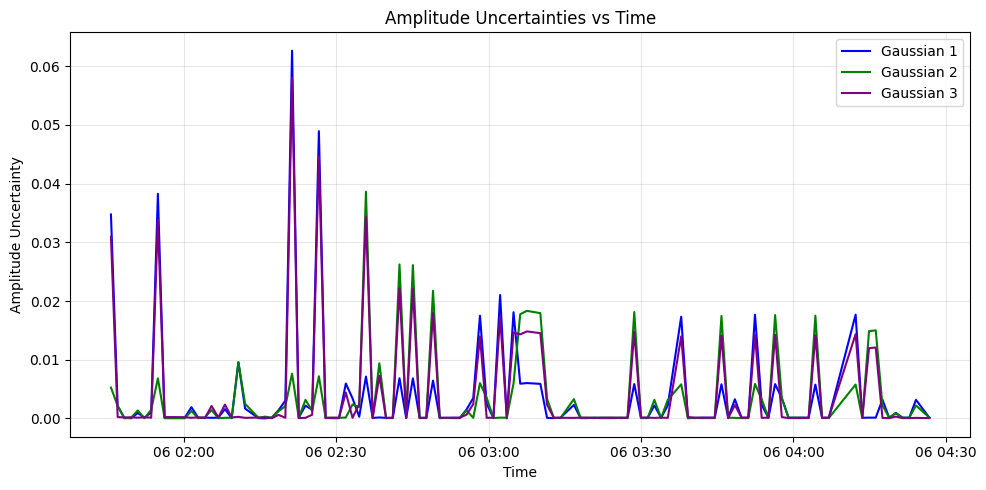

In [ ]:
# Amplitude Uncertainty Plot
plt.figure(figsize=(10, 5))
# Convert to Series for filtering
amp3_series = pd.Series(amp3_errs)
#filt_amp3 = amp3_series.where(amp3_series < 0.5)  # Keep only values < 0.5, others become NaN

plt.plot(fit_times, amp1_errs, label='Gaussian 1', color='blue')
plt.plot(fit_times, amp2_errs, label='Gaussian 2', color='green')
plt.plot(fit_times, amp3_errs, label='Gaussian 3', color='purple')
plt.title("Amplitude Uncertainties vs Time")
plt.ylabel("Amplitude Uncertainty")
plt.xlabel("Time")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

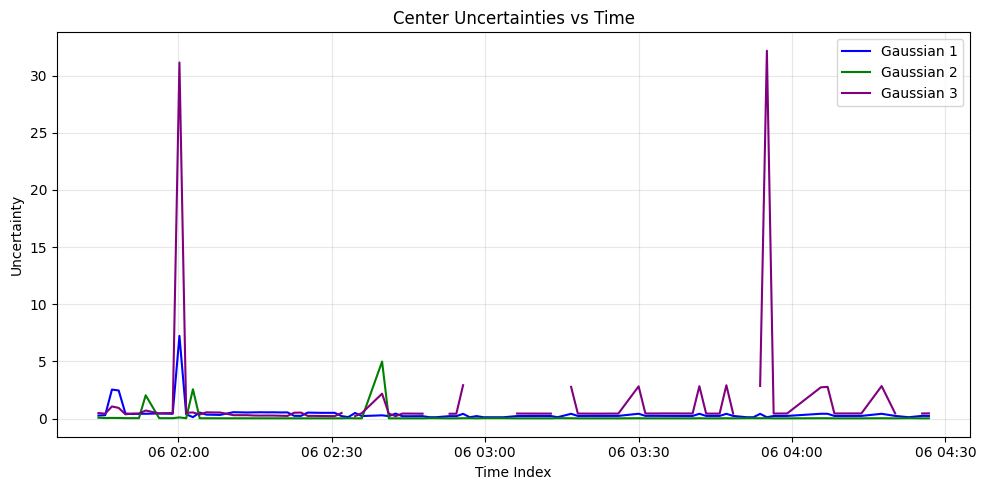

In [ ]:
# Center Uncertainty Plot
plt.figure(figsize=(10, 5))

cen3_series = pd.Series(cen3_errs)
filt_cen3 = cen3_series.where(cen3_series < 100)

plt.plot(fit_times, cen1_errs, label='Gaussian 1', color='blue')
plt.plot(fit_times, cen2_errs, label='Gaussian 2', color='green')
plt.plot(fit_times, filt_cen3, label='Gaussian 3', color='purple')
plt.title("Center Uncertainties vs Time")
plt.ylabel("Uncertainty")
plt.xlabel("Time Index")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

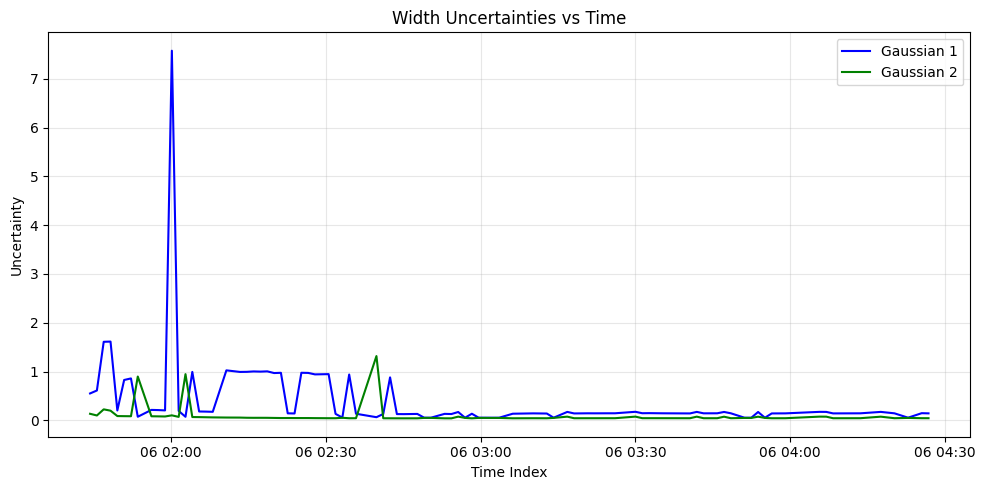

In [ ]:
# Width Uncertainty Plot
plt.figure(figsize=(10, 5))
plt.plot(fit_times, wid1_errs, label='Gaussian 1', color='blue')
plt.plot(fit_times, wid2_errs, label='Gaussian 2', color='green')
#plt.plot(fit_times, wid3_errs, label='Gaussian 3', color='purple')
plt.title("Width Uncertainties vs Time")
plt.ylabel("Uncertainty")
plt.xlabel("Time Index")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()